# Deep Generative Model

In this notebook we will implement a Gaussian VAE and a Bernoulli VAE on the MNIST dataset. After that we will compare them

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

latent_dim = 40
input_dim = 28*28
batch_size = 128
epochs = 150
learning_rate = 0.003
neurons = 256
activation = torch.tanh
train_loader = None
test_loader = None

## MNIST Dataset Preprocessing

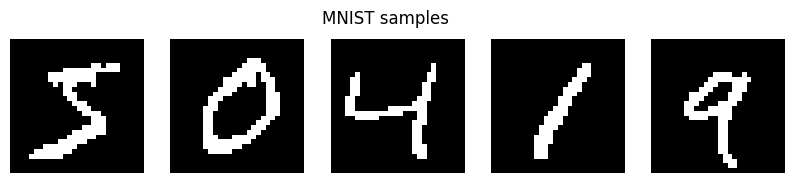

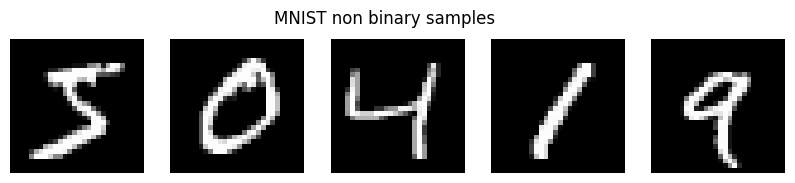

In [10]:
def load_data(binary=False):
    t = transforms.Compose([transforms.ToTensor()])
    t_bin = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: (x > 0.5).float())])

    if binary:
        t = t_bin
    
    mnist_train = datasets.MNIST('data', train=True, download=True, transform=t)
    mnist_test = datasets.MNIST('data', train=False, download=True, transform=t)
    
    return DataLoader(mnist_train, batch_size=batch_size, shuffle=True), DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

def plot_images(images, title):
    fig, axs = plt.subplots(1, len(images), figsize=(10, 2))
    for i, img in enumerate(images):
        axs[i].imshow(img.squeeze(), cmap='gray')
        axs[i].axis('off')
    plt.suptitle(title)
    plt.show()

train_loader, test_loader = load_data(binary=True)
plot_images([train_loader.dataset[i][0] for i in range(5)], 'MNIST samples')

train_loader, test_loader = load_data(binary=False)
plot_images([train_loader.dataset[i][0] for i in range(5)], 'MNIST non binary samples')

## Common

Implementation of the encoder and all the parts common to the 2 VAEs

In [11]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, neurons)
        self.fc_mu = nn.Linear(neurons, latent_dim)
        self.fc_logvar = nn.Linear(neurons, latent_dim)

    def forward(self, x):
        hidden = activation(self.fc1(x))
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        return mu, logvar
    
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z)
        return x_recon, x, mu, logvar
    
    
def train_vae(model, optimizer, loss_fn, sigma=None):
    model.train()
    history = []
    for epoch in tqdm(range(epochs), desc='Training Model', unit='epoch'):
        total_loss = 0
        for x, _ in train_loader:
            x = x.view(-1, input_dim)
            optimizer.zero_grad()
            args = model(x)
            if sigma:
                loss = loss_fn(args, sigma)
            else:
                loss = loss_fn(args)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            history.append(total_loss)
        print(f"Epoch {epoch+1}, Loss: {total_loss:.2f}")
    
    return history
    
def sample_and_plot(model, n=9):
    model.eval()
    with torch.no_grad():
        z = torch.randn(n, latent_dim)
        samples = model.decoder(z).view(-1, 1, 28, 28).cpu()
        grid = torch.cat([torch.cat([samples[i *3 + j] for j in range(3)], dim=2) for i in range(3)], dim=1)
        plt.imshow(grid.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()

## Bernoulli VAE

decoder and test code

Training Bernoulli VAE...


Training Model:   1%|          | 1/150 [00:15<37:52, 15.25s/epoch]

Epoch 1, Loss: 9041599.20


Training Model:   1%|▏         | 2/150 [00:30<37:38, 15.26s/epoch]

Epoch 2, Loss: 6626176.79


Training Model:   2%|▏         | 3/150 [00:45<36:33, 14.92s/epoch]

Epoch 3, Loss: 6166722.97


Training Model:   3%|▎         | 4/150 [00:59<36:17, 14.91s/epoch]

Epoch 4, Loss: 5936850.68


Training Model:   3%|▎         | 5/150 [01:13<35:15, 14.59s/epoch]

Epoch 5, Loss: 5797142.51


Training Model:   4%|▍         | 6/150 [01:28<35:01, 14.59s/epoch]

Epoch 6, Loss: 5692353.90


Training Model:   5%|▍         | 7/150 [01:42<34:30, 14.48s/epoch]

Epoch 7, Loss: 5618804.61


Training Model:   5%|▌         | 8/150 [01:56<34:02, 14.38s/epoch]

Epoch 8, Loss: 5553978.96


Training Model:   6%|▌         | 9/150 [02:11<33:42, 14.35s/epoch]

Epoch 9, Loss: 5515817.37


Training Model:   7%|▋         | 10/150 [02:26<33:55, 14.54s/epoch]

Epoch 10, Loss: 5473613.79


Training Model:   7%|▋         | 11/150 [02:39<32:56, 14.22s/epoch]

Epoch 11, Loss: 5449908.97


Training Model:   8%|▊         | 12/150 [02:55<33:44, 14.67s/epoch]

Epoch 12, Loss: 5422981.18


Training Model:   9%|▊         | 13/150 [03:15<37:09, 16.27s/epoch]

Epoch 13, Loss: 5399118.10


Training Model:   9%|▉         | 14/150 [03:37<41:07, 18.14s/epoch]

Epoch 14, Loss: 5379788.46


Training Model:  10%|█         | 15/150 [03:58<42:30, 18.89s/epoch]

Epoch 15, Loss: 5364079.87


Training Model:  11%|█         | 16/150 [04:22<45:56, 20.57s/epoch]

Epoch 16, Loss: 5347852.72


Training Model:  11%|█▏        | 17/150 [04:45<47:10, 21.28s/epoch]

Epoch 17, Loss: 5332431.66


Training Model:  12%|█▏        | 18/150 [05:07<46:52, 21.31s/epoch]

Epoch 18, Loss: 5324355.35


Training Model:  13%|█▎        | 19/150 [05:25<44:49, 20.53s/epoch]

Epoch 19, Loss: 5316353.52


Training Model:  13%|█▎        | 20/150 [05:43<42:45, 19.74s/epoch]

Epoch 20, Loss: 5300300.14


Training Model:  14%|█▍        | 21/150 [06:04<42:42, 19.87s/epoch]

Epoch 21, Loss: 5294386.91


Training Model:  15%|█▍        | 22/150 [06:22<41:45, 19.57s/epoch]

Epoch 22, Loss: 5283792.30


Training Model:  15%|█▌        | 23/150 [06:40<39:54, 18.85s/epoch]

Epoch 23, Loss: 5274510.23


Training Model:  16%|█▌        | 24/150 [06:59<39:39, 18.88s/epoch]

Epoch 24, Loss: 5263696.59


Training Model:  17%|█▋        | 25/150 [07:16<38:14, 18.35s/epoch]

Epoch 25, Loss: 5258292.31


Training Model:  17%|█▋        | 26/150 [07:34<37:37, 18.20s/epoch]

Epoch 26, Loss: 5259047.44


Training Model:  18%|█▊        | 27/150 [07:51<36:36, 17.86s/epoch]

Epoch 27, Loss: 5247026.82


Training Model:  19%|█▊        | 28/150 [08:08<35:49, 17.62s/epoch]

Epoch 28, Loss: 5239152.30


Training Model:  19%|█▉        | 29/150 [08:26<35:45, 17.73s/epoch]

Epoch 29, Loss: 5236820.42


Training Model:  20%|██        | 30/150 [08:43<35:32, 17.77s/epoch]

Epoch 30, Loss: 5230195.07


Training Model:  21%|██        | 31/150 [09:01<35:08, 17.72s/epoch]

Epoch 31, Loss: 5225556.82


Training Model:  21%|██▏       | 32/150 [09:18<34:34, 17.58s/epoch]

Epoch 32, Loss: 5222074.77


Training Model:  22%|██▏       | 33/150 [09:35<34:01, 17.45s/epoch]

Epoch 33, Loss: 5210823.54


Training Model:  23%|██▎       | 34/150 [09:53<33:50, 17.50s/epoch]

Epoch 34, Loss: 5212564.84


Training Model:  23%|██▎       | 35/150 [10:10<33:27, 17.46s/epoch]

Epoch 35, Loss: 5209808.20


Training Model:  24%|██▍       | 36/150 [10:29<33:48, 17.79s/epoch]

Epoch 36, Loss: 5204836.98


Training Model:  25%|██▍       | 37/150 [10:46<33:06, 17.58s/epoch]

Epoch 37, Loss: 5195138.92


Training Model:  25%|██▌       | 38/150 [11:03<32:31, 17.42s/epoch]

Epoch 38, Loss: 5197330.21


Training Model:  26%|██▌       | 39/150 [11:20<32:06, 17.35s/epoch]

Epoch 39, Loss: 5193046.96


Training Model:  27%|██▋       | 40/150 [11:38<31:48, 17.35s/epoch]

Epoch 40, Loss: 5192273.34


Training Model:  27%|██▋       | 41/150 [11:55<31:28, 17.32s/epoch]

Epoch 41, Loss: 5181111.64


Training Model:  28%|██▊       | 42/150 [12:12<31:04, 17.26s/epoch]

Epoch 42, Loss: 5179410.03


Training Model:  29%|██▊       | 43/150 [12:29<30:39, 17.19s/epoch]

Epoch 43, Loss: 5177264.53


Training Model:  29%|██▉       | 44/150 [12:47<30:52, 17.47s/epoch]

Epoch 44, Loss: 5176603.44


Training Model:  30%|███       | 45/150 [13:04<30:25, 17.39s/epoch]

Epoch 45, Loss: 5172594.32


Training Model:  31%|███       | 46/150 [13:21<29:55, 17.26s/epoch]

Epoch 46, Loss: 5169980.54


Training Model:  31%|███▏      | 47/150 [13:39<29:52, 17.40s/epoch]

Epoch 47, Loss: 5165198.95


Training Model:  32%|███▏      | 48/150 [13:59<30:41, 18.05s/epoch]

Epoch 48, Loss: 5161815.31


Training Model:  33%|███▎      | 49/150 [14:18<31:06, 18.48s/epoch]

Epoch 49, Loss: 5160950.79


Training Model:  33%|███▎      | 50/150 [14:37<30:45, 18.45s/epoch]

Epoch 50, Loss: 5164286.70


Training Model:  34%|███▍      | 51/150 [14:54<29:59, 18.18s/epoch]

Epoch 51, Loss: 5156141.45


Training Model:  35%|███▍      | 52/150 [15:13<29:58, 18.35s/epoch]

Epoch 52, Loss: 5156516.33


Training Model:  35%|███▌      | 53/150 [15:32<30:17, 18.73s/epoch]

Epoch 53, Loss: 5150048.76


Training Model:  36%|███▌      | 54/150 [15:50<29:23, 18.37s/epoch]

Epoch 54, Loss: 5146986.73


Training Model:  37%|███▋      | 55/150 [16:07<28:22, 17.92s/epoch]

Epoch 55, Loss: 5150333.30


Training Model:  37%|███▋      | 56/150 [16:24<27:44, 17.71s/epoch]

Epoch 56, Loss: 5144415.76


Training Model:  38%|███▊      | 57/150 [16:41<27:09, 17.52s/epoch]

Epoch 57, Loss: 5143631.99


Training Model:  39%|███▊      | 58/150 [16:59<26:49, 17.50s/epoch]

Epoch 58, Loss: 5137436.86


Training Model:  39%|███▉      | 59/150 [17:16<26:21, 17.38s/epoch]

Epoch 59, Loss: 5138829.36


Training Model:  40%|████      | 60/150 [17:33<26:01, 17.36s/epoch]

Epoch 60, Loss: 5137026.13


Training Model:  41%|████      | 61/150 [17:50<25:39, 17.30s/epoch]

Epoch 61, Loss: 5138893.49


Training Model:  41%|████▏     | 62/150 [18:07<25:13, 17.20s/epoch]

Epoch 62, Loss: 5127085.51


Training Model:  42%|████▏     | 63/150 [18:25<25:01, 17.25s/epoch]

Epoch 63, Loss: 5129887.03


Training Model:  43%|████▎     | 64/150 [18:42<24:41, 17.22s/epoch]

Epoch 64, Loss: 5130502.11


Training Model:  43%|████▎     | 65/150 [18:59<24:21, 17.19s/epoch]

Epoch 65, Loss: 5128109.43


Training Model:  44%|████▍     | 66/150 [19:16<24:07, 17.23s/epoch]

Epoch 66, Loss: 5123571.25


Training Model:  45%|████▍     | 67/150 [19:33<23:45, 17.18s/epoch]

Epoch 67, Loss: 5122584.66


Training Model:  45%|████▌     | 68/150 [19:50<23:32, 17.22s/epoch]

Epoch 68, Loss: 5125712.03


Training Model:  46%|████▌     | 69/150 [20:08<23:28, 17.39s/epoch]

Epoch 69, Loss: 5116990.54


Training Model:  47%|████▋     | 70/150 [20:26<23:16, 17.46s/epoch]

Epoch 70, Loss: 5123498.34


Training Model:  47%|████▋     | 71/150 [20:44<23:03, 17.51s/epoch]

Epoch 71, Loss: 5124690.15


Training Model:  48%|████▊     | 72/150 [21:01<22:48, 17.55s/epoch]

Epoch 72, Loss: 5118629.46


Training Model:  49%|████▊     | 73/150 [21:22<23:42, 18.47s/epoch]

Epoch 73, Loss: 5113787.40


Training Model:  49%|████▉     | 74/150 [21:43<24:18, 19.20s/epoch]

Epoch 74, Loss: 5116839.63


Training Model:  50%|█████     | 75/150 [22:00<23:28, 18.78s/epoch]

Epoch 75, Loss: 5113739.96


Training Model:  51%|█████     | 76/150 [22:20<23:32, 19.09s/epoch]

Epoch 76, Loss: 5110379.21


Training Model:  51%|█████▏    | 77/150 [22:41<23:45, 19.52s/epoch]

Epoch 77, Loss: 5109394.43


Training Model:  52%|█████▏    | 78/150 [23:02<23:53, 19.91s/epoch]

Epoch 78, Loss: 5109555.34


Training Model:  53%|█████▎    | 79/150 [23:23<24:08, 20.40s/epoch]

Epoch 79, Loss: 5108868.38


Training Model:  53%|█████▎    | 80/150 [23:44<24:03, 20.62s/epoch]

Epoch 80, Loss: 5112978.03


Training Model:  54%|█████▍    | 81/150 [24:05<23:44, 20.65s/epoch]

Epoch 81, Loss: 5100682.17


Training Model:  55%|█████▍    | 82/150 [24:27<23:45, 20.97s/epoch]

Epoch 82, Loss: 5108216.80


Training Model:  55%|█████▌    | 83/150 [24:48<23:38, 21.18s/epoch]

Epoch 83, Loss: 5106165.61


Training Model:  56%|█████▌    | 84/150 [25:10<23:30, 21.37s/epoch]

Epoch 84, Loss: 5103429.67


Training Model:  57%|█████▋    | 85/150 [25:28<21:58, 20.29s/epoch]

Epoch 85, Loss: 5097670.03


Training Model:  57%|█████▋    | 86/150 [25:48<21:31, 20.18s/epoch]

Epoch 86, Loss: 5100503.57


Training Model:  58%|█████▊    | 87/150 [26:09<21:32, 20.51s/epoch]

Epoch 87, Loss: 5101804.48


Training Model:  59%|█████▊    | 88/150 [26:30<21:19, 20.64s/epoch]

Epoch 88, Loss: 5093405.37


Training Model:  59%|█████▉    | 89/150 [26:47<19:55, 19.60s/epoch]

Epoch 89, Loss: 5097543.82


Training Model:  60%|██████    | 90/150 [27:05<18:56, 18.94s/epoch]

Epoch 90, Loss: 5096199.61


Training Model:  61%|██████    | 91/150 [27:22<18:06, 18.41s/epoch]

Epoch 91, Loss: 5095543.74


Training Model:  61%|██████▏   | 92/150 [27:39<17:28, 18.07s/epoch]

Epoch 92, Loss: 5090231.68


Training Model:  62%|██████▏   | 93/150 [27:58<17:29, 18.41s/epoch]

Epoch 93, Loss: 5092390.22


Training Model:  63%|██████▎   | 94/150 [28:19<17:40, 18.94s/epoch]

Epoch 94, Loss: 5093933.36


Training Model:  63%|██████▎   | 95/150 [28:38<17:35, 19.19s/epoch]

Epoch 95, Loss: 5091707.93


Training Model:  64%|██████▍   | 96/150 [28:56<16:49, 18.69s/epoch]

Epoch 96, Loss: 5087660.76


Training Model:  65%|██████▍   | 97/150 [29:14<16:15, 18.40s/epoch]

Epoch 97, Loss: 5094785.00


Training Model:  65%|██████▌   | 98/150 [29:31<15:36, 18.01s/epoch]

Epoch 98, Loss: 5079994.67


Training Model:  66%|██████▌   | 99/150 [29:51<16:00, 18.83s/epoch]

Epoch 99, Loss: 5085845.88


Training Model:  67%|██████▋   | 100/150 [30:11<15:58, 19.17s/epoch]

Epoch 100, Loss: 5085439.89


Training Model:  67%|██████▋   | 101/150 [30:30<15:30, 19.00s/epoch]

Epoch 101, Loss: 5089813.82


Training Model:  68%|██████▊   | 102/150 [30:47<14:49, 18.52s/epoch]

Epoch 102, Loss: 5084924.53


Training Model:  69%|██████▊   | 103/150 [31:04<14:10, 18.09s/epoch]

Epoch 103, Loss: 5081027.81


Training Model:  69%|██████▉   | 104/150 [31:23<14:01, 18.30s/epoch]

Epoch 104, Loss: 5078881.85


Training Model:  70%|███████   | 105/150 [31:43<14:05, 18.78s/epoch]

Epoch 105, Loss: 5078796.22


Training Model:  71%|███████   | 106/150 [32:01<13:35, 18.53s/epoch]

Epoch 106, Loss: 5084419.63


Training Model:  71%|███████▏  | 107/150 [32:20<13:16, 18.53s/epoch]

Epoch 107, Loss: 5074033.62


Training Model:  72%|███████▏  | 108/150 [32:40<13:21, 19.08s/epoch]

Epoch 108, Loss: 5077167.34


Training Model:  73%|███████▎  | 109/150 [32:57<12:39, 18.52s/epoch]

Epoch 109, Loss: 5074507.96


Training Model:  73%|███████▎  | 110/150 [33:15<12:11, 18.28s/epoch]

Epoch 110, Loss: 5079986.89


Training Model:  74%|███████▍  | 111/150 [33:35<12:12, 18.77s/epoch]

Epoch 111, Loss: 5076473.82


Training Model:  75%|███████▍  | 112/150 [33:55<12:12, 19.28s/epoch]

Epoch 112, Loss: 5078799.49


Training Model:  75%|███████▌  | 113/150 [34:18<12:26, 20.16s/epoch]

Epoch 113, Loss: 5077322.94


Training Model:  76%|███████▌  | 114/150 [34:37<11:53, 19.83s/epoch]

Epoch 114, Loss: 5073479.84


Training Model:  77%|███████▋  | 115/150 [34:58<11:52, 20.36s/epoch]

Epoch 115, Loss: 5071870.61


Training Model:  77%|███████▋  | 116/150 [35:17<11:16, 19.89s/epoch]

Epoch 116, Loss: 5076252.03


Training Model:  78%|███████▊  | 117/150 [35:36<10:49, 19.67s/epoch]

Epoch 117, Loss: 5069204.02


Training Model:  79%|███████▊  | 118/150 [35:56<10:30, 19.70s/epoch]

Epoch 118, Loss: 5072494.35


Training Model:  79%|███████▉  | 119/150 [36:16<10:15, 19.84s/epoch]

Epoch 119, Loss: 5070838.92


Training Model:  80%|████████  | 120/150 [36:36<09:52, 19.74s/epoch]

Epoch 120, Loss: 5076601.83


Training Model:  81%|████████  | 121/150 [36:57<09:43, 20.13s/epoch]

Epoch 121, Loss: 5077019.64


Training Model:  81%|████████▏ | 122/150 [37:16<09:14, 19.81s/epoch]

Epoch 122, Loss: 5063842.23


Training Model:  82%|████████▏ | 123/150 [37:33<08:35, 19.08s/epoch]

Epoch 123, Loss: 5069577.88


Training Model:  83%|████████▎ | 124/150 [37:54<08:31, 19.68s/epoch]

Epoch 124, Loss: 5067712.40


Training Model:  83%|████████▎ | 125/150 [38:14<08:12, 19.69s/epoch]

Epoch 125, Loss: 5066151.62


Training Model:  84%|████████▍ | 126/150 [38:34<07:58, 19.95s/epoch]

Epoch 126, Loss: 5068686.78


Training Model:  85%|████████▍ | 127/150 [38:54<07:35, 19.79s/epoch]

Epoch 127, Loss: 5067465.92


Training Model:  85%|████████▌ | 128/150 [39:14<07:20, 20.02s/epoch]

Epoch 128, Loss: 5063702.03


Training Model:  86%|████████▌ | 129/150 [39:35<07:07, 20.34s/epoch]

Epoch 129, Loss: 5062345.36


Training Model:  87%|████████▋ | 130/150 [39:56<06:48, 20.44s/epoch]

Epoch 130, Loss: 5061129.18


Training Model:  87%|████████▋ | 131/150 [40:16<06:26, 20.35s/epoch]

Epoch 131, Loss: 5065158.82


Training Model:  88%|████████▊ | 132/150 [40:38<06:13, 20.76s/epoch]

Epoch 132, Loss: 5064607.78


Training Model:  89%|████████▊ | 133/150 [40:59<05:54, 20.87s/epoch]

Epoch 133, Loss: 5061195.21


Training Model:  89%|████████▉ | 134/150 [41:15<05:10, 19.39s/epoch]

Epoch 134, Loss: 5058411.63


Training Model:  90%|█████████ | 135/150 [41:29<04:25, 17.71s/epoch]

Epoch 135, Loss: 5060330.28


Training Model:  91%|█████████ | 136/150 [41:42<03:48, 16.31s/epoch]

Epoch 136, Loss: 5055347.32


Training Model:  91%|█████████▏| 137/150 [41:55<03:18, 15.26s/epoch]

Epoch 137, Loss: 5057581.83


Training Model:  92%|█████████▏| 138/150 [42:07<02:54, 14.53s/epoch]

Epoch 138, Loss: 5060854.20


Training Model:  93%|█████████▎| 139/150 [42:21<02:35, 14.11s/epoch]

Epoch 139, Loss: 5060738.62


Training Model:  93%|█████████▎| 140/150 [42:33<02:16, 13.69s/epoch]

Epoch 140, Loss: 5056670.68


Training Model:  94%|█████████▍| 141/150 [42:46<02:01, 13.45s/epoch]

Epoch 141, Loss: 5059142.74


Training Model:  95%|█████████▍| 142/150 [43:01<01:50, 13.81s/epoch]

Epoch 142, Loss: 5054680.58


Training Model:  95%|█████████▌| 143/150 [43:15<01:38, 14.01s/epoch]

Epoch 143, Loss: 5058012.42


Training Model:  96%|█████████▌| 144/150 [43:29<01:23, 13.84s/epoch]

Epoch 144, Loss: 5057707.14


Training Model:  97%|█████████▋| 145/150 [43:45<01:12, 14.42s/epoch]

Epoch 145, Loss: 5050912.64


Training Model:  97%|█████████▋| 146/150 [43:58<00:56, 14.16s/epoch]

Epoch 146, Loss: 5057544.08


Training Model:  98%|█████████▊| 147/150 [44:12<00:42, 14.03s/epoch]

Epoch 147, Loss: 5052594.69


Training Model:  99%|█████████▊| 148/150 [44:25<00:27, 13.79s/epoch]

Epoch 148, Loss: 5051448.20


Training Model:  99%|█████████▉| 149/150 [44:38<00:13, 13.58s/epoch]

Epoch 149, Loss: 5054296.29


Training Model: 100%|██████████| 150/150 [44:51<00:00, 17.95s/epoch]

Epoch 150, Loss: 5049216.83
Samples from Bernoulli VAE:


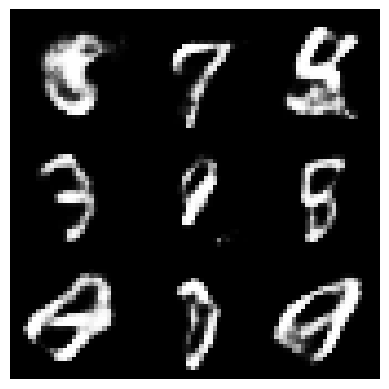

In [12]:
class BernoulliDecoder(nn.Module):
    def __init__(self):
        super(BernoulliDecoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, neurons)
        self.fc_out = nn.Linear(neurons, input_dim)

    def forward(self, x):
        hidden = activation(self.fc1(x))
        logits = self.fc_out(hidden)
        return torch.sigmoid(logits)
    

def bernoulli_loss(args):
    """
    Binary cross entropy loss function for Bernoulli distributed data.
    """
    x_recon, x, mu, logvar = args
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

vae_bernoulli = VAE(Encoder(), BernoulliDecoder())
optimizer = torch.optim.Adam(vae_bernoulli.parameters(), lr=learning_rate)

print("Training Bernoulli VAE...")
train_loader, test_loader = load_data(binary=True)
history = train_vae(vae_bernoulli, optimizer, bernoulli_loss)

print("Samples from Bernoulli VAE:")
sample_and_plot(vae_bernoulli)



## Gaussian VAE

decoder and test code

In [ ]:
class GaussianDecoder(BernoulliDecoder):
    def __init__(self):
        super(GaussianDecoder, self).__init__()

    def forward(self, x):
        hidden = activation(self.fc1(x))
        logits = self.fc_out(hidden)
        return logits
    
def gaussian_loss(args, sigma):
    """
    Mean squared error loss function for Gaussian distributed data.
    """
    x_recon, x, mu, logvar = args
    MSE = F.mse_loss(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE / (2*sigma**2) + KLD

sigmas = [0.01, 0.1, 1.0]

for sigma in sigmas:
    vae_gaussian = VAE(Encoder(), GaussianDecoder())
    optimizer = torch.optim.Adam(vae_gaussian.parameters(), lr=learning_rate)
    
    print("Training Gaussian VAE...")
    train_loader, test_loader = load_data(binary=False)
    history = train_vae(vae_gaussian, optimizer, gaussian_loss, sigma=sigma)

    print("Samples from Gaussian VAE:")
    sample_and_plot(vae_gaussian)
    

Training Gaussian VAE...


Training Model:   1%|          | 1/150 [00:11<28:24, 11.44s/epoch]

Epoch 1, Loss: 5112719111.00


Training Model:   1%|▏         | 2/150 [00:22<27:37, 11.20s/epoch]

Epoch 2, Loss: 3582342599.50


Training Model:   2%|▏         | 3/150 [00:33<27:37, 11.28s/epoch]

Epoch 3, Loss: 3474836643.00


Training Model:   3%|▎         | 4/150 [00:45<27:39, 11.36s/epoch]

Epoch 4, Loss: 3282771200.00


Training Model:   3%|▎         | 5/150 [00:56<27:12, 11.26s/epoch]

Epoch 5, Loss: 3114656996.50


Training Model:   4%|▍         | 6/150 [01:07<27:09, 11.32s/epoch]

Epoch 6, Loss: 2999037340.50


Training Model:   5%|▍         | 7/150 [01:18<26:43, 11.21s/epoch]

Epoch 7, Loss: 2910980566.00


Training Model:   5%|▌         | 8/150 [01:29<26:21, 11.14s/epoch]

Epoch 8, Loss: 2846415156.00


Training Model:   6%|▌         | 9/150 [01:40<26:09, 11.13s/epoch]

Epoch 9, Loss: 2788044932.00


Training Model:   7%|▋         | 10/150 [01:51<25:50, 11.07s/epoch]

Epoch 10, Loss: 2734181535.50


Training Model:   7%|▋         | 11/150 [02:02<25:37, 11.06s/epoch]

Epoch 11, Loss: 2694025874.50


Training Model:   8%|▊         | 12/150 [02:13<25:22, 11.04s/epoch]

Epoch 12, Loss: 2651431869.50


Training Model:   9%|▊         | 13/150 [02:24<25:07, 11.01s/epoch]

Epoch 13, Loss: 2615539375.00


Training Model:   9%|▉         | 14/150 [02:35<24:57, 11.01s/epoch]

Epoch 14, Loss: 2578402837.50


Training Model:  10%|█         | 15/150 [02:46<24:47, 11.02s/epoch]

Epoch 15, Loss: 2549963391.25


Training Model:  11%|█         | 16/150 [02:58<24:43, 11.07s/epoch]

Epoch 16, Loss: 2522581910.50


Training Model:  11%|█▏        | 17/150 [03:08<24:24, 11.01s/epoch]

Epoch 17, Loss: 2502183919.25


Training Model:  12%|█▏        | 18/150 [03:19<24:13, 11.01s/epoch]

Epoch 18, Loss: 2482405439.00


Training Model:  13%|█▎        | 19/150 [03:31<24:10, 11.07s/epoch]

Epoch 19, Loss: 2466255962.75


Training Model:  13%|█▎        | 20/150 [03:45<25:56, 11.97s/epoch]

Epoch 20, Loss: 2445008265.75


Training Model:  14%|█▍        | 21/150 [03:59<27:08, 12.62s/epoch]

Epoch 21, Loss: 2431378592.50


Training Model:  15%|█▍        | 22/150 [04:12<26:56, 12.63s/epoch]

Epoch 22, Loss: 2417534027.75


Training Model:  15%|█▌        | 23/150 [04:23<26:07, 12.34s/epoch]

Epoch 23, Loss: 2403956192.75


Training Model:  16%|█▌        | 24/150 [04:34<25:02, 11.92s/epoch]

Epoch 24, Loss: 2389661220.50


Training Model:  17%|█▋        | 25/150 [04:46<24:34, 11.80s/epoch]

Epoch 25, Loss: 2377645154.00


Training Model:  17%|█▋        | 26/150 [04:57<23:57, 11.60s/epoch]

Epoch 26, Loss: 2372413747.00


Training Model:  18%|█▊        | 27/150 [05:08<23:41, 11.55s/epoch]

Epoch 27, Loss: 2356601368.00


Training Model:  19%|█▊        | 28/150 [05:21<24:18, 11.95s/epoch]

Epoch 28, Loss: 2349482925.75


Training Model:  19%|█▉        | 29/150 [05:42<29:47, 14.77s/epoch]

Epoch 29, Loss: 2346572935.25


Training Model:  20%|██        | 30/150 [05:57<29:30, 14.75s/epoch]

Epoch 30, Loss: 2337153726.25


Training Model:  21%|██        | 31/150 [06:10<28:10, 14.20s/epoch]

Epoch 31, Loss: 2327462749.25


Training Model:  21%|██▏       | 32/150 [06:22<26:34, 13.51s/epoch]

Epoch 32, Loss: 2321749385.50


Training Model:  22%|██▏       | 33/150 [06:35<25:54, 13.29s/epoch]

Epoch 33, Loss: 2311308050.50


Training Model:  23%|██▎       | 34/150 [06:48<25:28, 13.17s/epoch]

Epoch 34, Loss: 2306685225.75


Training Model:  23%|██▎       | 35/150 [07:00<24:49, 12.95s/epoch]

Epoch 35, Loss: 2302245861.50


Training Model:  24%|██▍       | 36/150 [07:13<24:18, 12.79s/epoch]

Epoch 36, Loss: 2294137937.25


Training Model:  25%|██▍       | 37/150 [07:24<23:36, 12.54s/epoch]

Epoch 37, Loss: 2288990849.50


Training Model:  25%|██▌       | 38/150 [07:36<23:02, 12.34s/epoch]

Epoch 38, Loss: 2286769618.50


Training Model:  26%|██▌       | 39/150 [07:49<23:11, 12.54s/epoch]

Epoch 39, Loss: 2276977627.00


Training Model:  27%|██▋       | 40/150 [08:02<23:12, 12.66s/epoch]

Epoch 40, Loss: 2271207980.25


Training Model:  27%|██▋       | 41/150 [08:16<23:34, 12.97s/epoch]

Epoch 41, Loss: 2270439552.00


Training Model:  28%|██▊       | 42/150 [08:30<23:49, 13.23s/epoch]

Epoch 42, Loss: 2263123011.50


Training Model:  29%|██▊       | 43/150 [08:41<22:18, 12.51s/epoch]

Epoch 43, Loss: 2260265715.75


Training Model:  29%|██▉       | 44/150 [08:52<21:25, 12.13s/epoch]

Epoch 44, Loss: 2255497961.50


Training Model:  30%|███       | 45/150 [09:05<21:50, 12.48s/epoch]

Epoch 45, Loss: 2247138215.50


Training Model:  31%|███       | 46/150 [09:17<21:31, 12.42s/epoch]

Epoch 46, Loss: 2245535934.50


Training Model:  31%|███▏      | 47/150 [09:30<21:25, 12.48s/epoch]

Epoch 47, Loss: 2239215074.00


Training Model:  32%|███▏      | 48/150 [09:43<21:22, 12.57s/epoch]

Epoch 48, Loss: 2240734036.50


Training Model:  33%|███▎      | 49/150 [09:55<21:11, 12.59s/epoch]

Epoch 49, Loss: 2233918431.50


Training Model:  33%|███▎      | 50/150 [10:08<20:43, 12.43s/epoch]

Epoch 50, Loss: 2231360241.25


Training Model:  34%|███▍      | 51/150 [10:19<19:55, 12.07s/epoch]

Epoch 51, Loss: 2225585176.00


Training Model:  35%|███▍      | 52/150 [10:31<19:56, 12.20s/epoch]

Epoch 52, Loss: 2225240187.50


Training Model:  35%|███▌      | 53/150 [10:43<19:42, 12.19s/epoch]

Epoch 53, Loss: 2219170537.25


Training Model:  36%|███▌      | 54/150 [10:56<19:33, 12.22s/epoch]

Epoch 54, Loss: 2218767723.00


Training Model:  37%|███▋      | 55/150 [11:08<19:07, 12.08s/epoch]

Epoch 55, Loss: 2215746284.75


Training Model:  37%|███▋      | 56/150 [11:20<19:19, 12.34s/epoch]

Epoch 56, Loss: 2206141947.00


Training Model:  38%|███▊      | 57/150 [11:32<18:38, 12.03s/epoch]

Epoch 57, Loss: 2208546601.50


Training Model:  39%|███▊      | 58/150 [11:43<18:12, 11.87s/epoch]

Epoch 58, Loss: 2205787463.00


Training Model:  39%|███▉      | 59/150 [11:55<18:03, 11.91s/epoch]

Epoch 59, Loss: 2201182090.00


Training Model:  40%|████      | 60/150 [12:08<18:14, 12.16s/epoch]

Epoch 60, Loss: 2198887016.50


Training Model:  41%|████      | 61/150 [12:22<18:53, 12.73s/epoch]

Epoch 61, Loss: 2196040502.00


Training Model:  41%|████▏     | 62/150 [12:33<17:52, 12.19s/epoch]

Epoch 62, Loss: 2192418270.00


Training Model:  42%|████▏     | 63/150 [12:44<17:13, 11.88s/epoch]

Epoch 63, Loss: 2191069830.25


Training Model:  43%|████▎     | 64/150 [12:56<17:09, 11.97s/epoch]

Epoch 64, Loss: 2188805351.75


Training Model:  43%|████▎     | 65/150 [13:07<16:34, 11.70s/epoch]

Epoch 65, Loss: 2184039731.00


Training Model:  44%|████▍     | 66/150 [13:18<15:59, 11.42s/epoch]

Epoch 66, Loss: 2180968802.25


Training Model:  45%|████▍     | 67/150 [13:29<15:38, 11.30s/epoch]

Epoch 67, Loss: 2181310272.50


Training Model:  45%|████▌     | 68/150 [13:41<15:34, 11.40s/epoch]

Epoch 68, Loss: 2174964695.00


Training Model:  46%|████▌     | 69/150 [13:54<15:57, 11.82s/epoch]

Epoch 69, Loss: 2178188338.25


Training Model:  47%|████▋     | 70/150 [14:06<15:50, 11.88s/epoch]

Epoch 70, Loss: 2170188249.50


Training Model:  47%|████▋     | 71/150 [14:19<16:17, 12.38s/epoch]

Epoch 71, Loss: 2171452332.00


Training Model:  48%|████▊     | 72/150 [14:32<16:11, 12.45s/epoch]

Epoch 72, Loss: 2166150553.00


Training Model:  49%|████▊     | 73/150 [14:44<15:54, 12.40s/epoch]

Epoch 73, Loss: 2167142780.75


Training Model:  49%|████▉     | 74/150 [14:58<16:08, 12.74s/epoch]

Epoch 74, Loss: 2162497497.25


Training Model:  50%|█████     | 75/150 [15:12<16:22, 13.11s/epoch]

Epoch 75, Loss: 2161558849.75


Training Model:  51%|█████     | 76/150 [15:24<15:58, 12.95s/epoch]

Epoch 76, Loss: 2161656294.25


Training Model:  51%|█████▏    | 77/150 [15:37<15:42, 12.91s/epoch]

Epoch 77, Loss: 2157608946.75


Training Model:  52%|█████▏    | 78/150 [15:49<15:12, 12.67s/epoch]

Epoch 78, Loss: 2156664244.50


Training Model:  53%|█████▎    | 79/150 [16:02<14:54, 12.60s/epoch]

Epoch 79, Loss: 2154285204.50


Training Model:  53%|█████▎    | 80/150 [16:15<14:52, 12.74s/epoch]

Epoch 80, Loss: 2153069178.50


Training Model:  54%|█████▍    | 81/150 [16:29<15:12, 13.22s/epoch]

Epoch 81, Loss: 2155193780.50


## Comparison

generate images from different inputs and comment the results

Generating samples from binary inputs ...
Generating samples from non-binary inputs ...
Generating samples from random inputs ...
Generating samples from blank inputs ...


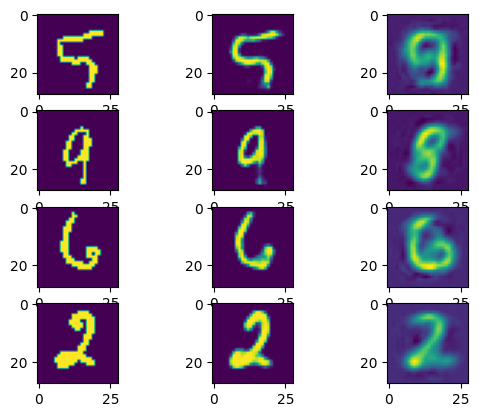

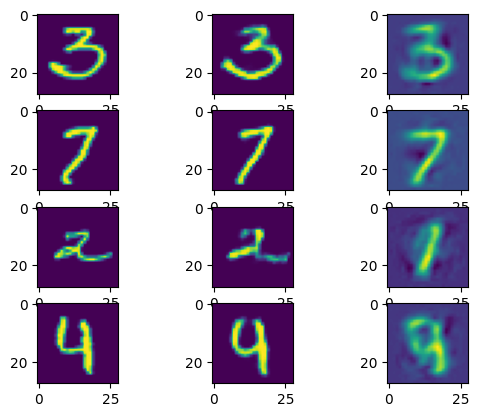

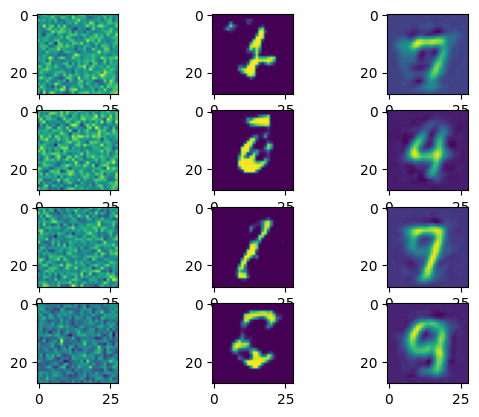

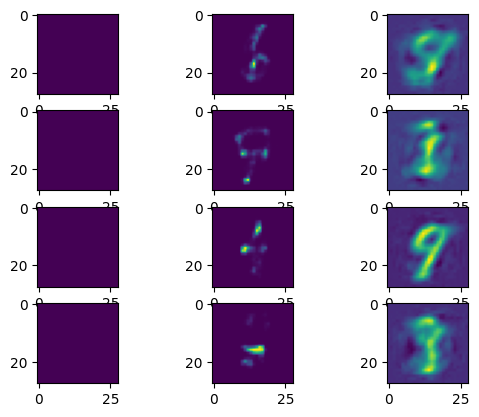

In [ ]:
def generate_mnist_from_iter(iter, n=4):
    vae_bernoulli.eval()
    vae_gaussian.eval()
    f, ax = plt.subplots(n,3)
    with torch.no_grad():
        for i in range(n):
            x, _ = next(iter)
            x = x.view(-1, input_dim)
            x_recon_bernoulli, _, _, _ = vae_bernoulli(x[0])
            x_recon_gaussian, _, _, _ = vae_gaussian(x[0])
            bernoulli = x_recon_bernoulli.reshape((28, 28))
            gaussian = x_recon_gaussian.reshape((28, 28))
            ax[i,0].imshow(x[0].view(28, 28).numpy())
            ax[i,1].imshow(bernoulli.detach().cpu().numpy())
            ax[i,2].imshow(gaussian.detach().cpu().numpy())
            
def generate_random_images_iterator():
    while True:
        yield torch.randn(1, 28*28), None

def generate_blank_images_iterator():
    while True:
        yield torch.zeros(1, 28*28), None


print("Generating samples from binary inputs ...")
generate_mnist_from_iter(iter(load_data(binary=True)[1]))

print("Generating samples from non-binary inputs ...")
generate_mnist_from_iter(iter(load_data(binary=False)[1]))

print("Generating samples from random inputs ...")
generate_mnist_from_iter(generate_random_images_iterator())

print("Generating samples from blank inputs ...")
generate_mnist_from_iter(generate_blank_images_iterator())